# OpenAI Assistants API

OpenAI's [Assistants API](https://platform.openai.com/docs/assistants/overview), which is currently in beta, lets you build AI assistants for your own applications. An assistant can leverage models, tools, and knowledge to respond to user queries. The Assistants API currently supports three types of tools: `Code Interpreter`, `Knowledge Retrieval`, and `Function Calling`. In the future, OpenAI plans to release more built-in tools and allow you to build tools of your own.

In [1]:
from openai import OpenAI

client = OpenAI(api_key='API_KEY')

## Knowledge Retrieval tool (RAG made easy)

The `Knowledge Retrieval` tools makes it easy to answer questions from curated sets of documents using [Retrieval Augmented Generation](https://arxiv.org/abs/2312.10997), or RAG. Let's demonstrate by building an assistant that can answer questions about electric vehicles (EVs) using three government PDFs as its knowledge base. Begin by loading the PDFs.

In [2]:
file1 = client.files.create(
    file=open('Data/electric_vehicles.pdf', 'rb'),
    purpose='assistants'
)

file2 = client.files.create(
    file=open('Data/pev_consumer_handbook.pdf', 'rb'),
    purpose='assistants'
)


file3 = client.files.create(
    file=open('Data/department-for-transport-ev-guide.pdf', 'rb'),
    purpose='assistants'
)

Now create an assistant that uses the `Knowledge Retrieval` tool and upload the PDFs.

In [3]:
assistant = client.beta.assistants.create(
    instructions='You are a transportation expert who can answer questions about electric vehicles.',
    model='gpt-4-turbo-preview',
    tools=[{ 'type': 'retrieval' }],
    file_ids=[file1.id, file2.id, file3.id]
)

Ask the assistant a question about electric vehicles.

In [4]:
import time

# Create a message thread
thread = client.beta.threads.create()

# Add a message to the message thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role='user',
    content='How far can an EV travel on a single charge?'
)

# Initiate a run and loop until it completes
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

while run.status == 'queued' or run.status == 'in_progress':
    time.sleep(2)
    
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    
    print(run.status)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed


If the run completed successfully, show the response.

In [5]:
if run.status == 'completed':
    messages = client.beta.threads.messages.list(thread_id=thread.id)
    print(messages.data[0].content[0].text.value)

The distance an electric vehicle (EV) can travel on a single charge, known as its range, varies significantly depending on the make and model of the vehicle, battery capacity, driving conditions, and driving habits. As of my last update in 2023, here is a general overview:

1. **Entry-level EVs** typically offer a range of about 100 to 150 miles (160 to 240 kilometers) on a full charge. These are usually more affordable models designed for city driving and short commutes.

2. **Mid-tier EVs** often have ranges between 200 to 300 miles (320 to 480 kilometers). This category includes a broad spectrum of vehicles, from compact cars to SUVs, capable of accommodating most daily needs and longer commutes.

3. **High-end or long-range EVs** can exceed 300 miles (roughly 480 kilometers), with some models boasting ranges up to 400 miles (about 640 kilometers) or more on a single charge. These vehicles typically come with a higher price tag and are aimed at consumers looking for the maximum rang

## Function Calling tool (computing distances)

The `Function Calling` tool lets you extend an LLM's capabilities by providing functions that it can call to execute tasks that it isn't capable of executing on its own. To demonstrate, let's give an LLM the ability to compute distances between points on a map using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). Start by asking `GPT-4` to compute the distance between two locations.

In [6]:
prompt = '''
An airplane flies from one location at latitude 36.010357, longitude -84.269646
(Oak Ridge, TN) to another location at latitude 37.681873, longitude -121.768005
(Livermore, CA). How far did the airplane travel?
'''

messages = [{ 'role': 'user', 'content': prompt }]

response = client.chat.completions.create(
    model='gpt-4-turbo-preview',
    messages=messages
)

print(response.choices[0].message.content)

To approximate the distance an airplane travels between two points on the Earth's surface given their latitudes and longitudes, we often use the haversine formula. The haversine formula gives the great-circle distance between two points, which is the shortest distance over the Earth's surface, giving an "as-the-crow-flies" distance between the points (ignoring any hills, valleys, or other potential obstructions).

The haversine formula is as follows:

\[ a = \sin^2\left(\frac{\Delta\varphi}{2}\right) + \cos(\varphi_1) \cdot \cos(\varphi_2) \cdot \sin^2\left(\frac{\Delta\lambda}{2}\right) \]

\[ c = 2 \cdot \text{atan2}\left(\sqrt{a}, \sqrt{1-a}\right) \]

\[ d = R \cdot c \]

Where:
- \(\varphi_1\) and \(\varphi_2\) are the latitudes of the two points in radians,
- \(\Delta\varphi\) is the difference between the latitudes,
- \(\Delta\lambda\) is the difference between the longitudes (in radians),
- \(R\) is the Earth's radius (mean radius = 6,371 km),
- \(d\) is the distance between th

Define a function that accepts two latitudes and longitudes as input and returns the distance between them in miles.

In [7]:
import math
import numpy as np

def get_haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth = 3958.8  # Radius of Earth in miles
    return np.abs(radius_earth * c)

Describe the function and its parameters to the Assistants API.

In [8]:
tools = [
    {
        'type': 'function',
        'function': {
            'name': 'get_haversine_distance',
            'description': 'Computes the distance in miles between two latitudes and longitudes',
            'parameters': {
                'type': 'object',
                'properties': {
                    'lat1': {
                        'type': 'number',
                        'description': 'Latitude at the origin'
                    },
                    'lon1': {
                        'type': 'number',
                        'description': 'Longitude at the origin'
                    },
                    'lat2': {
                        'type': 'number',
                        'description': 'Latitude at the destination'
                    },
                    'lon2': {
                        'type': 'number',
                        'description': 'Longitude at the destination'
                    }
                },
                'required': ['lat1', 'lon1', 'lat2', 'lon2']
            }
        }
    },
]

Create an assistant that's aware of the function.

In [9]:
assistant = client.beta.assistants.create(
    instructions='You are a helpful assistant who can provide information about distances traveled.',
    model='gpt-4-1106-preview',
    tools=tools
)

Feed the same prompt as before to the assistant.

In [10]:
import json

# Create a message thread
thread = client.beta.threads.create()

# Add a message to the message thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role='user',
    content=prompt
)

# Initiate a run and loop until it completes
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

while run.status == 'queued' or run.status == 'in_progress' or run.status == 'requires_action':
    time.sleep(1)

    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )

    print(f'Run status: { run.status }')

    # If the run requires further action, perform the action
    if run.status == 'requires_action':
        tool_outputs = []

        for tool_call in run.required_action.submit_tool_outputs.tool_calls:
            function_name = tool_call.function.name

            if function_name == 'get_haversine_distance':
                print('Calling get_haversine_distance()')
                lat1 = json.loads(tool_call.function.arguments)['lat1']
                lon1 = json.loads(tool_call.function.arguments)['lon1']
                lat2 = json.loads(tool_call.function.arguments)['lat2']
                lon2 = json.loads(tool_call.function.arguments)['lon2']
                output = get_haversine_distance(lat1, lon1, lat2, lon2)
            else:
                raise Exception('Invalid function name')

            tool_output = {
                'tool_call_id': tool_call.id,
                'output': output
            }

            tool_outputs.append(tool_output)        

        # Pass the tool output to the Assistants API
        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )

Run status: in_progress
Run status: in_progress
Run status: requires_action
Calling get_haversine_distance()
Run status: in_progress
Run status: completed


If the run completed successfully, show the response.

In [11]:
if run.status == 'completed':
    messages = client.beta.threads.messages.list(thread_id=thread.id)
    print(messages.data[0].content[0].text.value)

The airplane traveled approximately 2062.76 miles from Oak Ridge, TN to Livermore, CA.


## Code Interpreter tool (chart generation)

The `Code Interpreter` tool responds to user queries by generating and executing Python code. One use for it is generating charts and graphs from data you provide. To demonstrate, let's create an assistant that knows about the tool and pass it the contents of a CSV file containing information about delays at major airports. Here's the CSV file:

In [12]:
import pandas as pd

df = pd.read_csv('Data/delays.csv')
df.head(None)

,Airport,Average Delay
0,ATL,22
1,JFK,146
2,LGA,98
3,DTW,13
4,MCO,12
5,MCI,12
6,LHR,33
7,CDG,45
8,LAX,26


Now create an assistant and make the CSV file available to it.

In [13]:
file = client.files.create(
    file=open('Data/delays.csv', 'rb'),
    purpose='assistants'
)

assistant = client.beta.assistants.create(
    instructions='You are a helpful assistant who can generate informative charts and graphs from CSV files.',
    tools=[{ 'type': 'code_interpreter' }],
    file_ids=[file.id],
    model='gpt-4-turbo-preview'
)

Ask the assistant to generate a chart from the data in the CSV file.

In [14]:
# Create a message thread
thread = client.beta.threads.create()

# Add a message to the message thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role='user',
    content='Generate a colorful histogram showing delays at various airports.',
    file_ids=[file.id]
)

# Initiate a run and loop until it completes
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

while run.status == 'queued' or run.status == 'in_progress':
    time.sleep(5)
    
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    
    print(run.status)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed


If the call was successful, get the response and display the image that was generated.

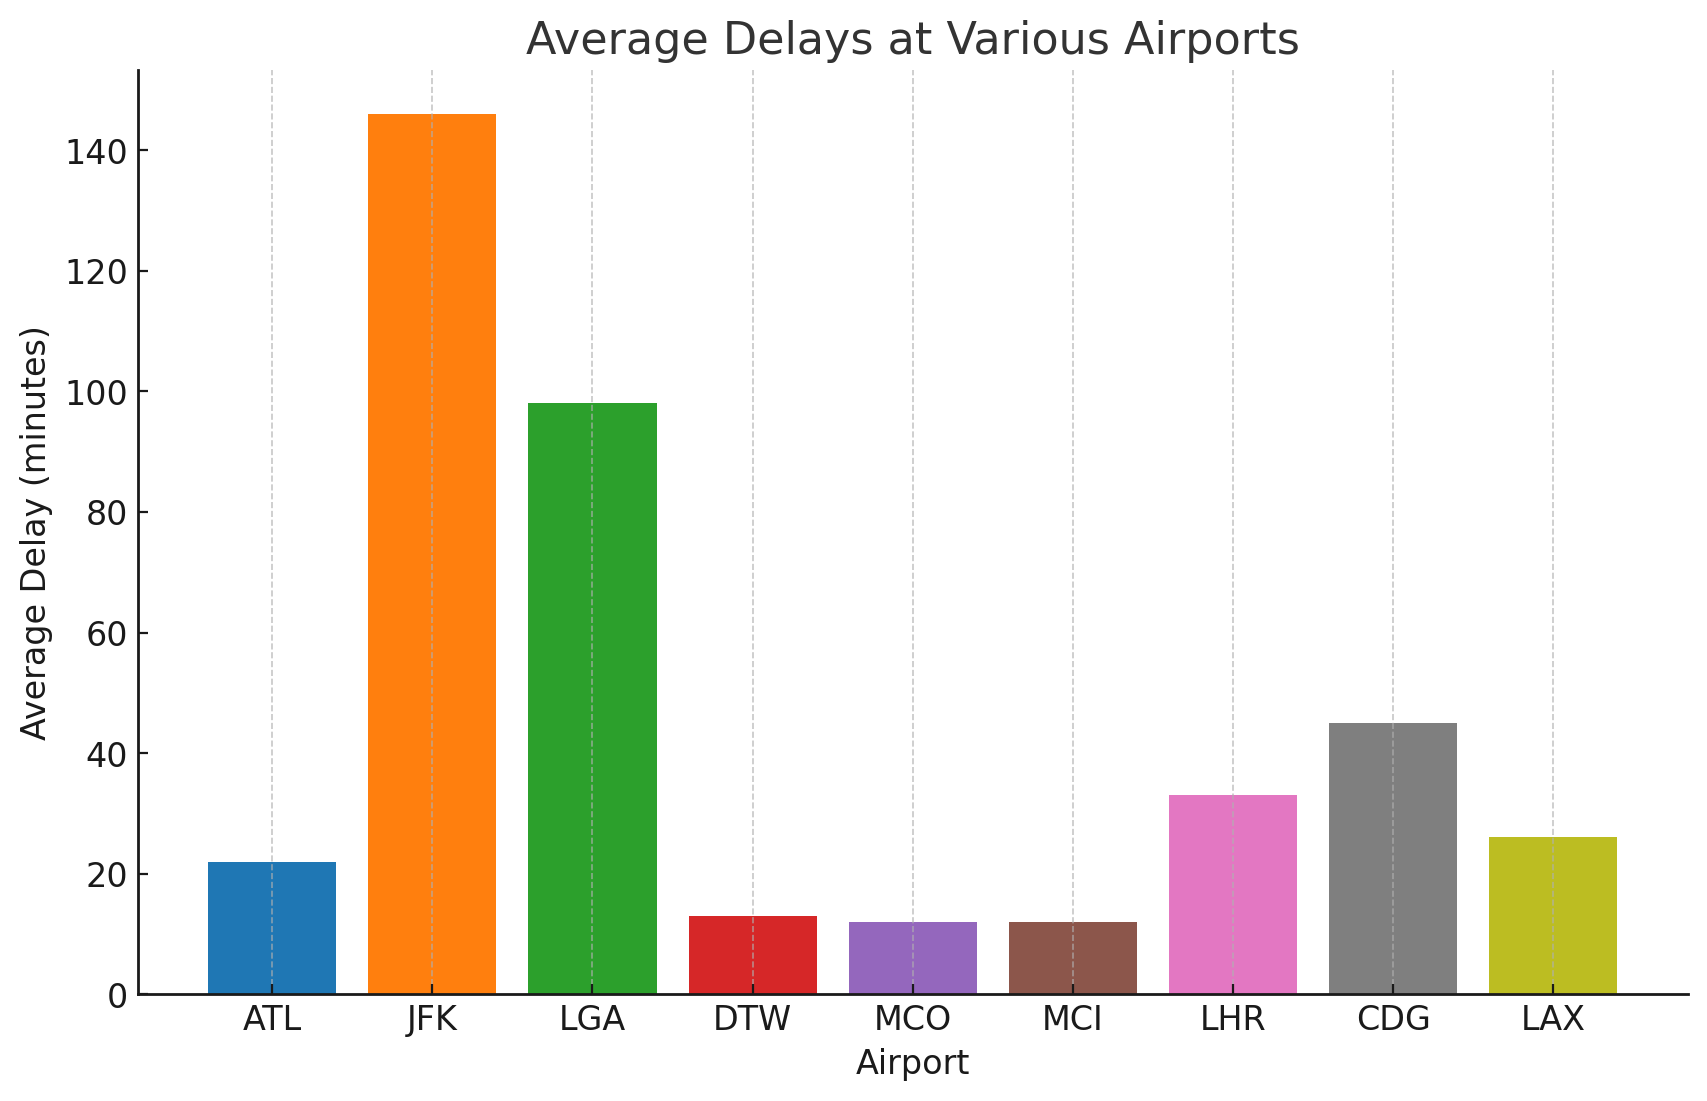

In [15]:
from IPython.display import display, Image

if run.status == 'completed':
    messages = client.beta.threads.messages.list(thread_id=thread.id)

    file_id = messages.data[0].content[0].image_file.file_id
    image_file = client.files.content(file_id)
    image_bytes = image_file.read()
    
    display(Image(image_bytes))